# Curiosities of European Soccer

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This data set from Kaggle brings data of soccer from european leagues, teams and players from 2008 to 2016.
* +25,000 matches
* +10,000 players
* 11 European Countries with their lead championship

Some question I will try to answer here in this work:

1. asd


Import libs used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

Load data for Players from database.sqlite witch is in the same folder of the notebook.
The columns 'overall_rating' and 'penalties' will be used to answer some questions.

In [123]:
players_query = '''
                SELECT DISTINCT player_name, p.player_api_id, date, overall_rating, aggression, height, weight
                FROM player p JOIN player_attributes pa
                ON p.player_api_id=pa.player_api_id;
                '''

with sqlite3.connect('database.sqlite') as con:
    players = pd.read_sql_query(players_query, con)
    
players.head()    

,player_name,player_api_id,date,overall_rating,aggression,height,weight
0,Aaron Appindangoye,505942,2016-02-18 00:00:00,67.0,71.0,182.88,187
1,Aaron Appindangoye,505942,2015-11-19 00:00:00,67.0,71.0,182.88,187
2,Aaron Appindangoye,505942,2015-09-21 00:00:00,62.0,63.0,182.88,187
3,Aaron Appindangoye,505942,2015-03-20 00:00:00,61.0,62.0,182.88,187
4,Aaron Appindangoye,505942,2007-02-22 00:00:00,61.0,62.0,182.88,187


Analise the data looking for inconsistences (duplicates, missing values..).

In [124]:
# There are some duplicated values that need to be cleaned.
sum(players.duplicated(subset=['player_api_id']))

172917

In [125]:
# We also have some missing values.
players.isnull().any()

player_name       False
player_api_id     False
date              False
overall_rating     True
aggression         True
height            False
weight            False
dtype: bool

Another data need to answer the last question is about teams and matchs.

In [40]:
match_query = '''
                SELECT date, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
                FROM Match
                WHERE date like '2016%';
                '''

with sqlite3.connect('database.sqlite') as con:
    match = pd.read_sql_query(match_query, con)
    
match.head()   

,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,2016-01-16 00:00:00,8342,274581,3,0
1,2016-01-17 00:00:00,9991,8635,2,0
2,2016-01-15 00:00:00,9987,10000,2,1
3,2016-01-17 00:00:00,8573,8475,3,3
4,2016-01-17 00:00:00,9994,9985,0,2


In [41]:
team_query = '''
                SELECT date, team_api_id, buildUpPlaySpeed, buildUpPlayDribbling, buildUpPlayPassing
                FROM Team_Attributes ORDER BY date DESC;
                '''

with sqlite3.connect('database.sqlite') as con:
    team = pd.read_sql_query(team_query, con)
    
team.head()  

,date,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing
0,2015-09-10 00:00:00,9930,47,41.0,54
1,2015-09-10 00:00:00,8485,59,64.0,53
2,2015-09-10 00:00:00,8576,59,57.0,52
3,2015-09-10 00:00:00,8564,48,70.0,52
4,2015-09-10 00:00:00,10215,53,53.0,44


We will genarate another table the make the analysis easier. The final data frame will have the difference of the home and aways teams on goals and attributes.

In [42]:
temp1 = match.merge(team, left_on='home_team_api_id', right_on='team_api_id', how='left')
temp1.head()

,date_x,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,date_y,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing
0,2016-01-16 00:00:00,8342,274581,3,0,2015-09-10 00:00:00,8342.0,42.0,52.0,45.0
1,2016-01-16 00:00:00,8342,274581,3,0,2014-09-19 00:00:00,8342.0,42.0,52.0,45.0
2,2016-01-16 00:00:00,8342,274581,3,0,2013-09-20 00:00:00,8342.0,45.0,NaN,48.0
3,2016-01-16 00:00:00,8342,274581,3,0,2012-02-22 00:00:00,8342.0,64.0,NaN,54.0
4,2016-01-16 00:00:00,8342,274581,3,0,2011-02-22 00:00:00,8342.0,67.0,NaN,47.0


In [43]:
temp2 = temp1.merge(team, left_on='away_team_api_id', right_on='team_api_id', how='left')
temp2.head()

,date_x,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,date_y,team_api_id_x,buildUpPlaySpeed_x,buildUpPlayDribbling_x,buildUpPlayPassing_x,date,team_api_id_y,buildUpPlaySpeed_y,buildUpPlayDribbling_y,buildUpPlayPassing_y
0,2016-01-16 00:00:00,8342,274581,3,0,2015-09-10 00:00:00,8342.0,42.0,52.0,45.0,2015-09-10 00:00:00,274581.0,50.0,50.0,50.0
1,2016-01-16 00:00:00,8342,274581,3,0,2014-09-19 00:00:00,8342.0,42.0,52.0,45.0,2015-09-10 00:00:00,274581.0,50.0,50.0,50.0
2,2016-01-16 00:00:00,8342,274581,3,0,2013-09-20 00:00:00,8342.0,45.0,NaN,48.0,2015-09-10 00:00:00,274581.0,50.0,50.0,50.0
3,2016-01-16 00:00:00,8342,274581,3,0,2012-02-22 00:00:00,8342.0,64.0,NaN,54.0,2015-09-10 00:00:00,274581.0,50.0,50.0,50.0
4,2016-01-16 00:00:00,8342,274581,3,0,2011-02-22 00:00:00,8342.0,67.0,NaN,47.0,2015-09-10 00:00:00,274581.0,50.0,50.0,50.0


In [44]:
temp3 = temp2[['home_team_goal', 
                        'away_team_goal', 
                        'buildUpPlaySpeed_x', 
                        'buildUpPlayDribbling_x', 
                        'buildUpPlayPassing_x', 
                        'buildUpPlaySpeed_y', 
                        'buildUpPlayDribbling_y', 
                        'buildUpPlayPassing_y',
                       ]].copy()

temp3.head()

,home_team_goal,away_team_goal,buildUpPlaySpeed_x,buildUpPlayDribbling_x,buildUpPlayPassing_x,buildUpPlaySpeed_y,buildUpPlayDribbling_y,buildUpPlayPassing_y
0,3,0,42.0,52.0,45.0,50.0,50.0,50.0
1,3,0,42.0,52.0,45.0,50.0,50.0,50.0
2,3,0,45.0,NaN,48.0,50.0,50.0,50.0
3,3,0,64.0,NaN,54.0,50.0,50.0,50.0
4,3,0,67.0,NaN,47.0,50.0,50.0,50.0


In [45]:
temp3['goals_diff'] = temp3['home_team_goal'] - temp3['away_team_goal']
temp3['speed_diff'] = temp3['buildUpPlaySpeed_x'] - temp3['buildUpPlaySpeed_y']
temp3['bribbling_diff'] = temp3['buildUpPlayDribbling_x'] - temp3['buildUpPlayDribbling_y']
temp3['passing_diff'] = temp3['buildUpPlayPassing_x'] - temp3['buildUpPlayPassing_y']
temp3.head()

,home_team_goal,away_team_goal,buildUpPlaySpeed_x,buildUpPlayDribbling_x,buildUpPlayPassing_x,buildUpPlaySpeed_y,buildUpPlayDribbling_y,buildUpPlayPassing_y,goals_diff,speed_diff,bribbling_diff,passing_diff
0,3,0,42.0,52.0,45.0,50.0,50.0,50.0,3,-8.0,2.0,-5.0
1,3,0,42.0,52.0,45.0,50.0,50.0,50.0,3,-8.0,2.0,-5.0
2,3,0,45.0,NaN,48.0,50.0,50.0,50.0,3,-5.0,NaN,-2.0
3,3,0,64.0,NaN,54.0,50.0,50.0,50.0,3,14.0,NaN,4.0
4,3,0,67.0,NaN,47.0,50.0,50.0,50.0,3,17.0,NaN,-3.0


In [46]:
complete_match = temp3[['goals_diff', 'speed_diff', 'bribbling_diff', 'passing_diff']].copy()
complete_match.head()

,goals_diff,speed_diff,bribbling_diff,passing_diff
0,3,-8.0,2.0,-5.0
1,3,-8.0,2.0,-5.0
2,3,-5.0,NaN,-2.0
3,3,14.0,NaN,4.0
4,3,17.0,NaN,-3.0


In [ ]:
We will need some clean to remove null values.

In [38]:
complete_match.isnull().any()

goals_diff        False
speed_diff         True
bribbling_diff     True
passing_diff       True
dtype: bool

### Data Cleaning

In [ ]:
We will remove the duplicated values keeping the first ones because they are the most updated ones.

In [126]:
players.drop_duplicates(subset=['player_api_id'], inplace=True)
sum(players.duplicated(subset=['player_api_id']))

0

As we found that there are some missing values, we will remove it.

In [127]:
players.dropna(inplace=True)
players.isnull().any()

player_name       False
player_api_id     False
date              False
overall_rating    False
aggression        False
height            False
weight            False
dtype: bool

For the matchs we will get only the most update data that will correspond to 2016 matchs.

In [23]:
team.drop_duplicates(subset=['team_api_id'], inplace=True)
sum(team.duplicated(subset=['team_api_id']))

0

Now we will clean the matchs.

In [48]:
complete_match.dropna(inplace=True)
complete_match.isnull().any()

goals_diff        False
speed_diff        False
bribbling_diff    False
passing_diff      False
dtype: bool

<a id='eda'></a>
## Exploratory Data Analysis

### Who are the best players on Europe?

To answer this question we will use the rating number providade by each players. The most recent rating will be considered.

In [110]:
# Sorting by rating and geting the the important values
top_players_rating = players.sort_values(by=['overall_rating'], ascending=False)[:5][['player_name', 'overall_rating']]

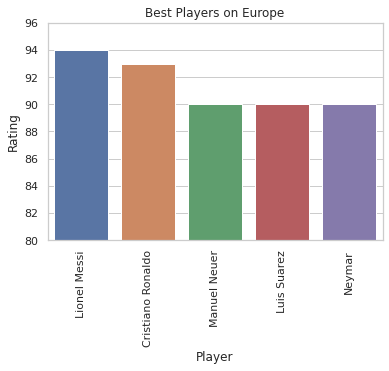

In [111]:
# Ploting player vs ratings
sns.set_theme(style='whitegrid')
fig = sns.barplot(x='player_name', y='overall_rating', data=top_players_rating)
plt.setp(fig.get_xticklabels(), rotation=90)
plt.ylim(80, 96)
fig.set(xlabel='Player', ylabel='Rating', title='Best Players on Europe');

### Who are the player with higher aggression rating?

In [112]:
# Sorting by agression and geting the the important values
top_players_aggression = players.sort_values(by=['aggression'], ascending=False)[:5][['player_name', 'aggression']]

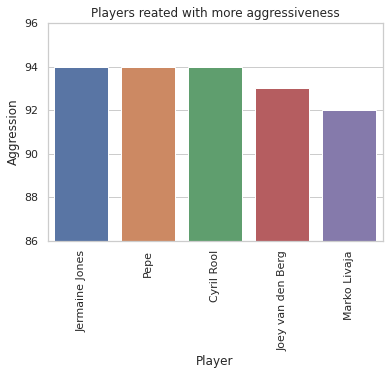

In [118]:
# Ploting player vs aggression
sns.set_theme(style='whitegrid')
fig = sns.barplot(x='player_name', y='aggression', data=top_players_aggression)
plt.setp(fig.get_xticklabels(), rotation=90)
plt.ylim(86, 96)
fig.set(xlabel='Player', ylabel='Aggression', title='Players reated with more aggressiveness');

### Is the player rating related to agressiveness?

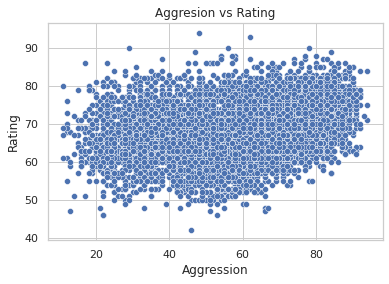

In [122]:
# Ploting rating vs agression
sns.set_theme(style='whitegrid')
fig = sns.scatterplot(x="aggression", y="overall_rating", data=players)
fig.set(xlabel='Aggression', ylabel='Rating', title='Aggresion vs Rating');

For the data we didn't find any strong corelation for these two parameters. I was expecting to see some corelation here.

### How the players are distributed by their physical form (measured by the Body Mass Index).

In [140]:
players['BMI'] = (players['weight'] / 2.205) / ((players['height'] / 100) ** 2)
players.describe()

,player_api_id,overall_rating,aggression,height,weight,BMI
count,11060.000000,11060.000000,11060.000000,11060.000000,11060.000000,11060.000000
mean,156582.427215,67.961935,61.008951,181.867445,168.380289,23.061806
std,160713.700624,6.316694,16.254977,6.369201,14.990217,1.316878
min,2625.000000,42.000000,11.000000,157.480000,117.000000,17.586568
25%,35555.500000,64.000000,52.000000,177.800000,159.000000,22.170941
50%,96619.500000,68.000000,64.000000,182.880000,168.000000,23.051962
75%,212470.500000,72.000000,73.000000,185.420000,179.000000,23.867438
max,750584.000000,94.000000,94.000000,208.280000,243.000000,30.860445


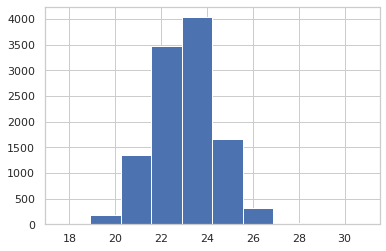

In [138]:
players['BMI'].hist();

By the BMI index, below 18.5 is under a healthy weight and above 30 is considered obesity.
By this histogram we can see that professional soccer player in most cases have a good boddy structure.

### Teams playing at home won more matchs?

To answer this question we can use the goals difference.

In [53]:
home_victory = complete_match.apply(lambda x: True if x['goals_diff'] > 0 else False , axis=1)
numOfHomeVictory = len(home_victory[home_victory == True].index)

away_victory = complete_match.apply(lambda x: True if x['goals_diff'] < 0 else False , axis=1)
numOfAwayVictory = len(away_victory[away_victory == True].index)

draws_game = complete_match.apply(lambda x: True if x['goals_diff'] == 0 else False , axis=1)
numOfDraws = len(draws_game[draws_game == True].index)

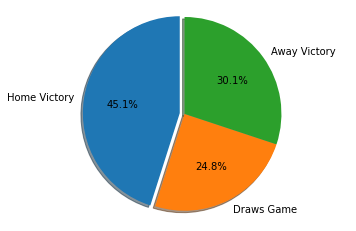

In [62]:
labels = 'Home Victory', 'Draws Game', 'Away Victory'
sizes = [numOfHomeVictory, numOfDraws, numOfAwayVictory]
explode = (0.05, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

In our data for 2016 the teams playing at home have won more. At least for the data remaning after the clean.

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!